In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import glob

Data Pipeline

In [2]:
filepaths = glob.glob('datasets\Tumor\yes\*.jpg') + glob.glob('datasets\Tumor\yes\*.JPG') +glob.glob('datasets\Tumor\yes\*.png')
filepaths_negative =   glob.glob('datasets\\Tumor\\no\\*.jpg') + glob.glob('datasets\\Tumor\\no\\*.jpeg')

In [3]:
def preprocess_to_tensors(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img.set_shape([None, None, 3])
        img = tf.image.resize(img , [218, 180])
        return img
    except tf.errors.InvalidArgumentError:
        # Skip files that are not in a supported format
        return None

In [4]:
def preprocess_to_tensors_no(file_path):
    img = tf.io.read_file(tf.cast(file_path, tf.string))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize_with_pad(img, 218, 180)
    return img

In [5]:
imgtensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(filepaths)
dataset = dataset.map(preprocess_to_tensors)
for img in dataset:
    imgtensorarray = imgtensorarray.write(imgtensorarray.size(), img)

train_yes = imgtensorarray.stack()

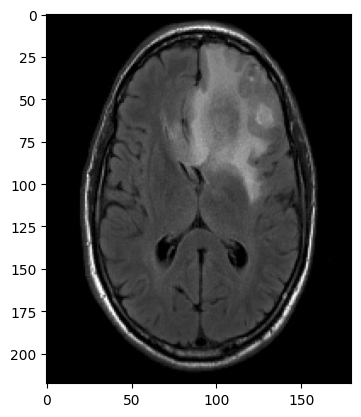

In [7]:
plt.figure()
plt.imshow(train_yes[68])

In [8]:
train_yes.shape

TensorShape([309, 218, 180, 3])

In [9]:
dataset_negative = tf.data.Dataset.from_tensor_slices(filepaths_negative)
dataset_negative = dataset_negative.map(preprocess_to_tensors_no)

In [10]:
img_negative_tensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)
for neg_img in dataset_negative:
    img_negative_tensorarray = img_negative_tensorarray.write(img_negative_tensorarray.size(), neg_img)


train_no = img_negative_tensorarray.stack()

In [11]:
train_no.shape

TensorShape([97, 218, 180, 3])

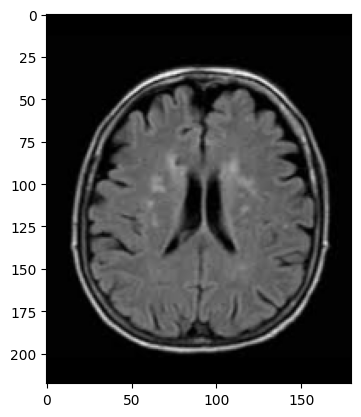

In [12]:
plt.imshow(train_no[6])

In [13]:
train_x = tf.concat([train_yes, train_no], axis = 0)
train_x.shape

TensorShape([406, 218, 180, 3])

In [14]:
y_yes = tf.ones(train_yes.shape[0], 1)
y_no = tf.zeros(train_no.shape[0], 1)

In [15]:
train_y = tf.concat([y_yes,y_no], axis = 0)

In [16]:
train_y = tf.reshape(train_y, (train_y.shape[0], 1))

In [17]:
train_y.shape

TensorShape([406, 1])

In [18]:
permutation = tf.random.shuffle(tf.range(tf.shape(train_x)[0]))
train_x = tf.gather(train_x , permutation)
train_y = tf.gather(train_y, permutation)

In [19]:
train_x = tf.data.Dataset.from_tensor_slices(train_x)
train_y = tf.data.Dataset.from_tensor_slices(train_y)

In [20]:
train_dataset = tf.data.Dataset.zip((train_x,train_y))
train_dataset = train_dataset.batch(32)

### Utility Functions:

In [21]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='my_logs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

run_logdir = get_run_logdir()

In [22]:
import os


model_dir = 'path/to/model/directory'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'TumorDetection_best.keras')

## Model

In [23]:
@tf.keras.utils.register_keras_serializable()
class TumorDetectionNeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.base_preprocess_ = tf.keras.applications.xception.preprocess_input
        self.base_model = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=False)
        self.base_model.trainable = False
        self.avg = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_1 = tf.keras.layers.Dense(256 , activation = tf.keras.activations.relu,
                                        kernel_initializer = tf.keras.initializers.GlorotNormal() )
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.dense_2 = tf.keras.layers.Dense(128, activation = tf.keras.activations.relu , 
                                        kernel_initializer = tf.keras.initializers.GlorotNormal() )
        self.drop2 = tf.keras.layers.Dropout(0.3)
        self.output_ = tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)

    def call(self, inputs , training = False):
        x = self.base_preprocess_(inputs)
        x = self.base_model(x, training=training)
        x = self.avg(x)
        x = self.dense_1(x)
        x = self.drop1(x, training=training)
        x = self.dense_2(x)
        x = self.drop2(x, training=training)
        return self.output_(x)

In [24]:
class DelayModelGraph(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_at_epoch, new_lr, **kwargs):
        super().__init__(**kwargs)
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.new_lr = new_lr

    def on_epoch_begin(self, epoch, logs=None):
        if epoch + 1 == self.unfreeze_at_epoch:
            print(f"Base model type: {type(self.model.base_model)}, base model name: {self.model.base_model.name}")
            self.model.base_model.trainable = True
            new_optimizer = tf.keras.optimizers.Adam(learning_rate=self.new_lr)
            self.model.optimizer = new_optimizer

            print(f"\nEpoch {epoch + 1}: Unfroze base model layers and updated learning rate to {self.new_lr}")

class TensorBoardFeatureMapVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, frequency=1, **kwargs):
        super().__init__(**kwargs)
        self.freq = frequency
        self.writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.freq == 0:
            base_model = self.model.base_model
            self.intermediate_model = tf.keras.Model(inputs=base_model.inputs,
                                                     outputs=[layer.output for layer in base_model.layers if isinstance(layer, tf.keras.layers.Conv2D)])
            self.subject_image = next(iter(train_dataset.take(1)))[0][0:1]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.freq == 0:
            feature_maps = self.intermediate_model.predict(self.subject_image)
            with self.writer.as_default():
                for i, feature_map in enumerate(feature_maps):
                    feature_map = tf.reduce_mean(feature_map, axis=-1, keepdims=True)
                    tf.summary.image('FeatureMap_{}'.format(i), feature_map, step=epoch)

## HyperModel Tuner

In [25]:
import keras_tuner as kt
class XceptionbasedCNNTuner(kt.HyperModel):
    def build(self, hp):
        learning_rate = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling= 'log')
        optimizer = hp.Choice('optimizer', values = ['adam', 'sgd'])
        if optimizer=='adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        else :
            optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate , momentum = 0.9)    
        model = TumorDetectionNeuralNet()
        model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                      optimizer = optimizer,
                      metrics = ['accuracy'])
        return model

In [26]:
HyperModelTuner = kt.BayesianOptimization(hypermodel = XceptionbasedCNNTuner(),
                                          objective= 'accuracy',
                                          max_trials= 10,
                                          directory = 'TumorDetetcion Hypermodel',
                                          project_name = 'TunerTrials',
                                          seed = 42)

Reloading Tuner from TumorDetetcion Hypermodel\TunerTrials\tuner0.json


In [27]:
HyperModelTuner.search(train_dataset, epochs = 30)

In [28]:
HyperModelTuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.005977728042983696, 'optimizer': 'adam'}

In [29]:
lr = HyperModelTuner.get_best_hyperparameters()[0].values['learning_rate']
optm = HyperModelTuner.get_best_hyperparameters()[0].values['optimizer']

In [30]:
model = TumorDetectionNeuralNet()

In [31]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
              metrics =['accuracy'])

In [32]:
model.fit(train_dataset , epochs = 50 , callbacks = [DelayModelGraph(25 , new_lr= 0.001) ,
                                                     tf.keras.callbacks.ModelCheckpoint(filepath = model_path,
                                                                                        monitor = 'accuracy',
                                                                                        save_weights_only = False,
                                                                                        save_best_only = True,
                                                                                        verbose = 1),
                                                     tf.keras.callbacks.TensorBoard(run_logdir),
                                                     TensorBoardFeatureMapVisualizer(str(run_logdir))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7170 - loss: 0.6267
Epoch 1: accuracy improved from -inf to 0.73645, saving model to path/to/model/directory\TumorDetection_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7184 - loss: 0.6250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7856 - loss: 0.4619
Epoch 2: accuracy improved from 0.73645 to 0.76847, saving model to path/to/model/directory\TumorDetection_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7844 - loss: 0.4648
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8081 - loss: 0.4565
Epoch 3: accuracy improved from 0.76847 to 0.78325, saving model to path/to/model/directory\TumorDetection_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8063 - loss: 0.4573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 4/50
13/13 ━━━━━━━━━━━

In [33]:
best_model = tf.keras.models.load_model('path\\to\\model\\directory\\TumorDetection_best.keras', 
                                        custom_objects={'TumorDetectionNeuralNet': TumorDetectionNeuralNet})

C:\Users\isthi\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Testing

In [34]:
for img , label in train_dataset.take(1):
    #test1 = tf.expand_dims(img[0] , 0)
    test2 = img
    test2_labels = label

In [35]:
y_pred = best_model.predict(test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [36]:
class_labels = np.where(y_pred > 0.5, 'Tumor', 'No Tumor')
true_labels = np.where(test2_labels > 0.5 , 'Tumor' , 'No Tumor')

In [37]:
class_labels , true_labels

(array([['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['No Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['No Tumor'],
        ['No Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['No Tumor'],
        ['Tumor'],
        ['Tumor']], dtype='<U8'),
 array([['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['No Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
        ['Tumor'],
 

In [38]:
best_model.evaluate(train_dataset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9811 - loss: 0.0792


[0.08668679744005203, 0.9778324961662292]

In [39]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = 'hotizontal' , seed = 42),
    tf.keras.layers.RandomRotation(factor = 0.05, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2 , seed=42)
])

In [40]:
for img in train_x.batch(32).take(1):
    augmented_test1 = img

In [41]:
augmented_test1.shape

TensorShape([32, 218, 180, 3])

In [42]:
augmented_test = data_augmentation(augmented_test1)

In [43]:
augmented_test.shape

TensorShape([32, 218, 180, 3])

In [44]:
augmented_predict = best_model.predict(augmented_test1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [45]:
class_labelsaug = np.where(augmented_predict > 0.5 , 'Tumor', 'No Tumor')

In [46]:
class_labelsaug

array([['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['Tumor']], dtype='<U8')

In [47]:
yes_test = tf.data.Dataset.from_tensor_slices(train_yes).batch(16)

In [48]:
for img in yes_test.take(1):
    augmented_test2 = img

In [49]:
augmented_test2 = data_augmentation(augmented_test2)

In [50]:
augyespred = best_model.predict(augmented_test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [51]:
augyespredlabels = np.where(augyespred > 0 , 'Tumor', 'No Tumor')

In [52]:
augyespredlabels

array([['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor'],
       ['Tumor']], dtype='<U8')

In [53]:
train_no.shape

TensorShape([97, 218, 180, 3])

In [54]:
no_test = tf.data.Dataset.from_tensor_slices(train_no).batch(16)

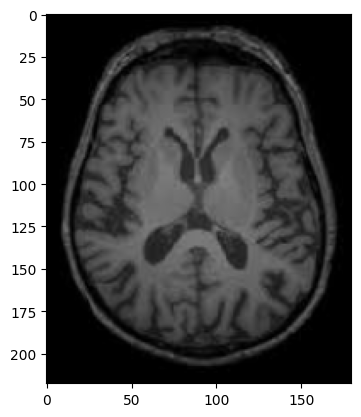

In [55]:
for img in no_test.take(1):
    img1 = img[0]
    plt.imshow(img1)

In [56]:
images = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)

In [57]:
for noimg in no_test.take(1):
    augmented_test3 = noimg

In [58]:
augmented_test3 = data_augmentation(augmented_test3)

In [59]:
augnopred = best_model.predict(augmented_test3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


In [60]:
augnopredlabels = np.where(augnopred > 0.5 , 'Tumor', 'No Tumor')

In [61]:
augnopredlabels

array([['Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['Tumor'],
       ['No Tumor'],
       ['No Tumor'],
       ['Tumor']], dtype='<U8')

## Model Analysis:

So the predictions are really promising. Yes I do lack a proper validations set to actually see how well my model has generalised but nonetheless it does tell me that the model has generalised well on the training dataset I used.

I have achieved an accuracy of more than 97% using transfer learning by importing the Xception net with imagenet weights, and the training time is significantly low considering these results.

## Learning Curves:

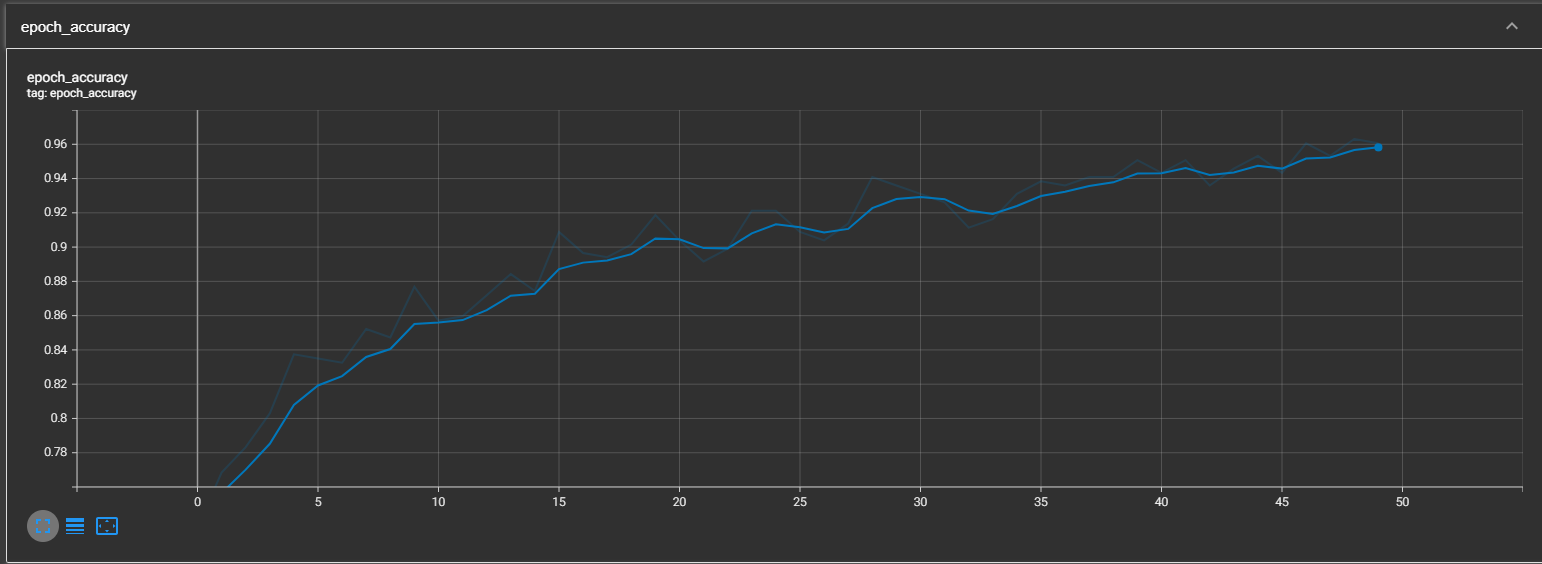

As we can see the accuracy curve seems fairly smooth.The curve seems to have slightly stagnated for some epochs after epoch no.25 but that is to be expected considering that I have unfroze the base model to start training its weights there. This was implemented by my DelayModelGrpahs(tf.keras.callbacks.callback) instance .

## Learning Rate curves:

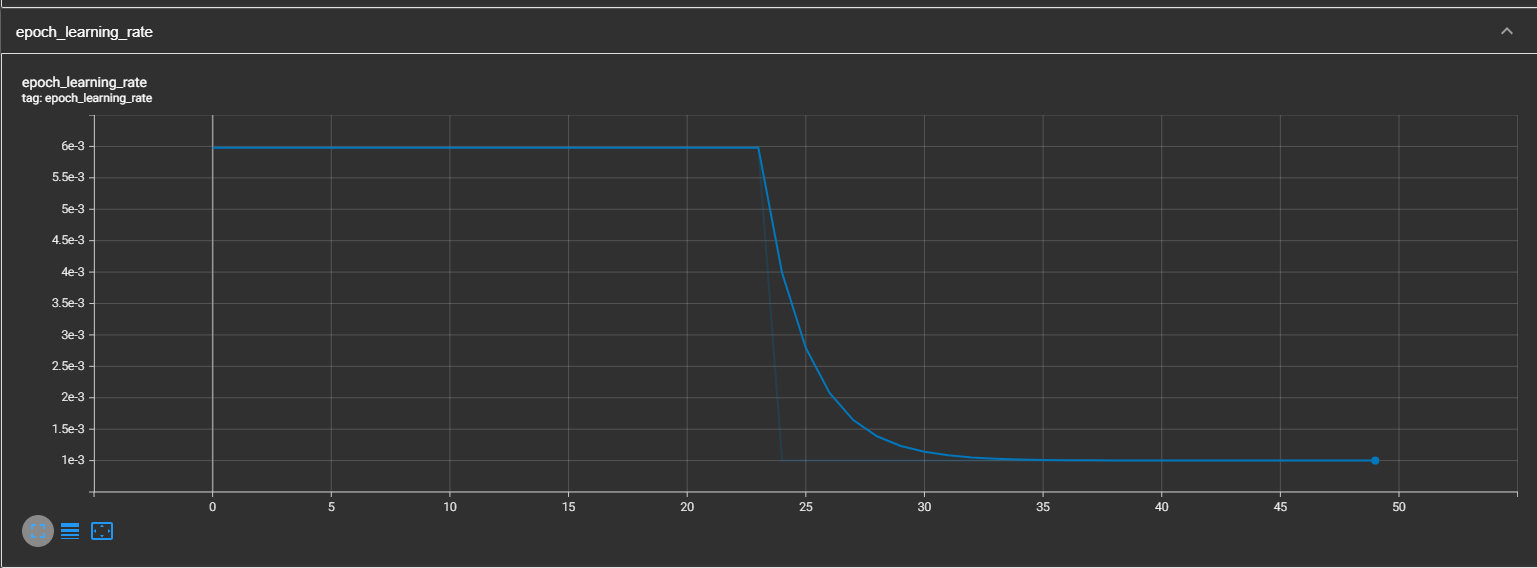

So as we can see the epoch curve shows a dip after epoch number 25 ( It is a smoothed curve so it shows the dip to have started earlier).

This is also because of my DelayModelGraph(tf.keras.callbacks.Callback) instance which also changes the optimizer by using a new learning rate which is fairly smaller than the previous one.

This is done so that once the Dense net has been initialised and trianed over the datset for some epochs, its weights will now have values close wnough to not diminish the convolutions done by the unfrozen transfered model. This helps in significantly improving the training speed and accuracy of the model.

## Feature Maps:

I have also implemented a custom TensorBoardFeatureMapVisualizer(tf.keras.callbacks.Callback) class that basically logs all the feature maps and the changes in the feature maps that happen as the model weights get updated. This allows us to get a better picture at the convolutions that happen during training . here are some of the feature maps :

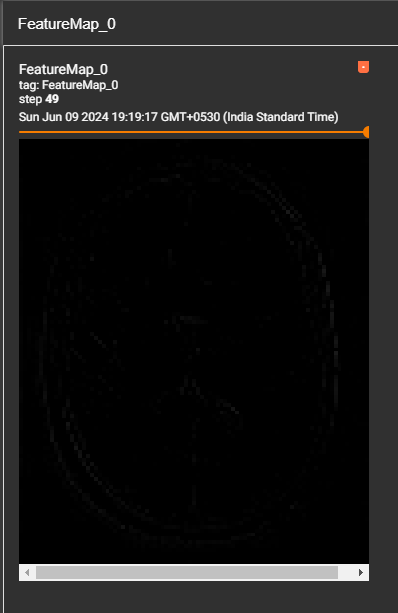  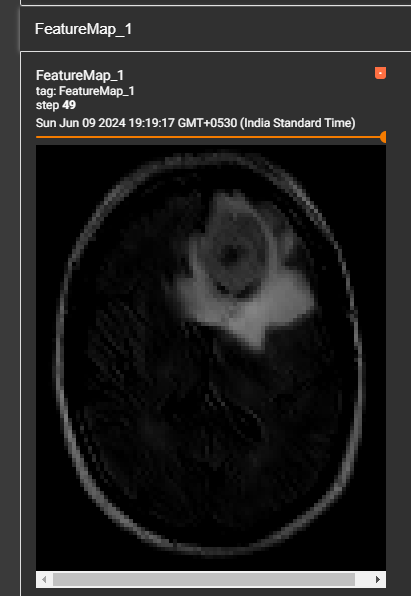  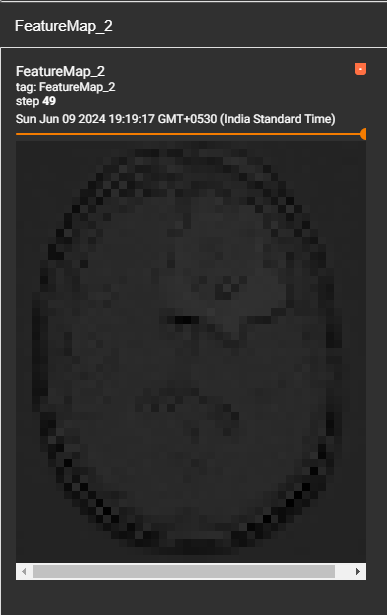  

As you can see the model has generalised well to understand the important features and extracted those features efficiently . These are the feature maps of the same image and we can see how the model has processed them 

## Learning Analysis and Model Scope:
So the model seems to have generalised well . And the results are very promising . we can see how it has managed to learn and detect tumors.  
The model has a great scope for imporvement. With a better dataset and proper feature localisation the model would have learned even better and generalised even more. However since there are not many sources to obtain medical scans its hard to have a bigger datset. 

In conclusion the model performs well and generalises well . It can succesfully be depolyed with a few changes.

## Authenticity and commit history :

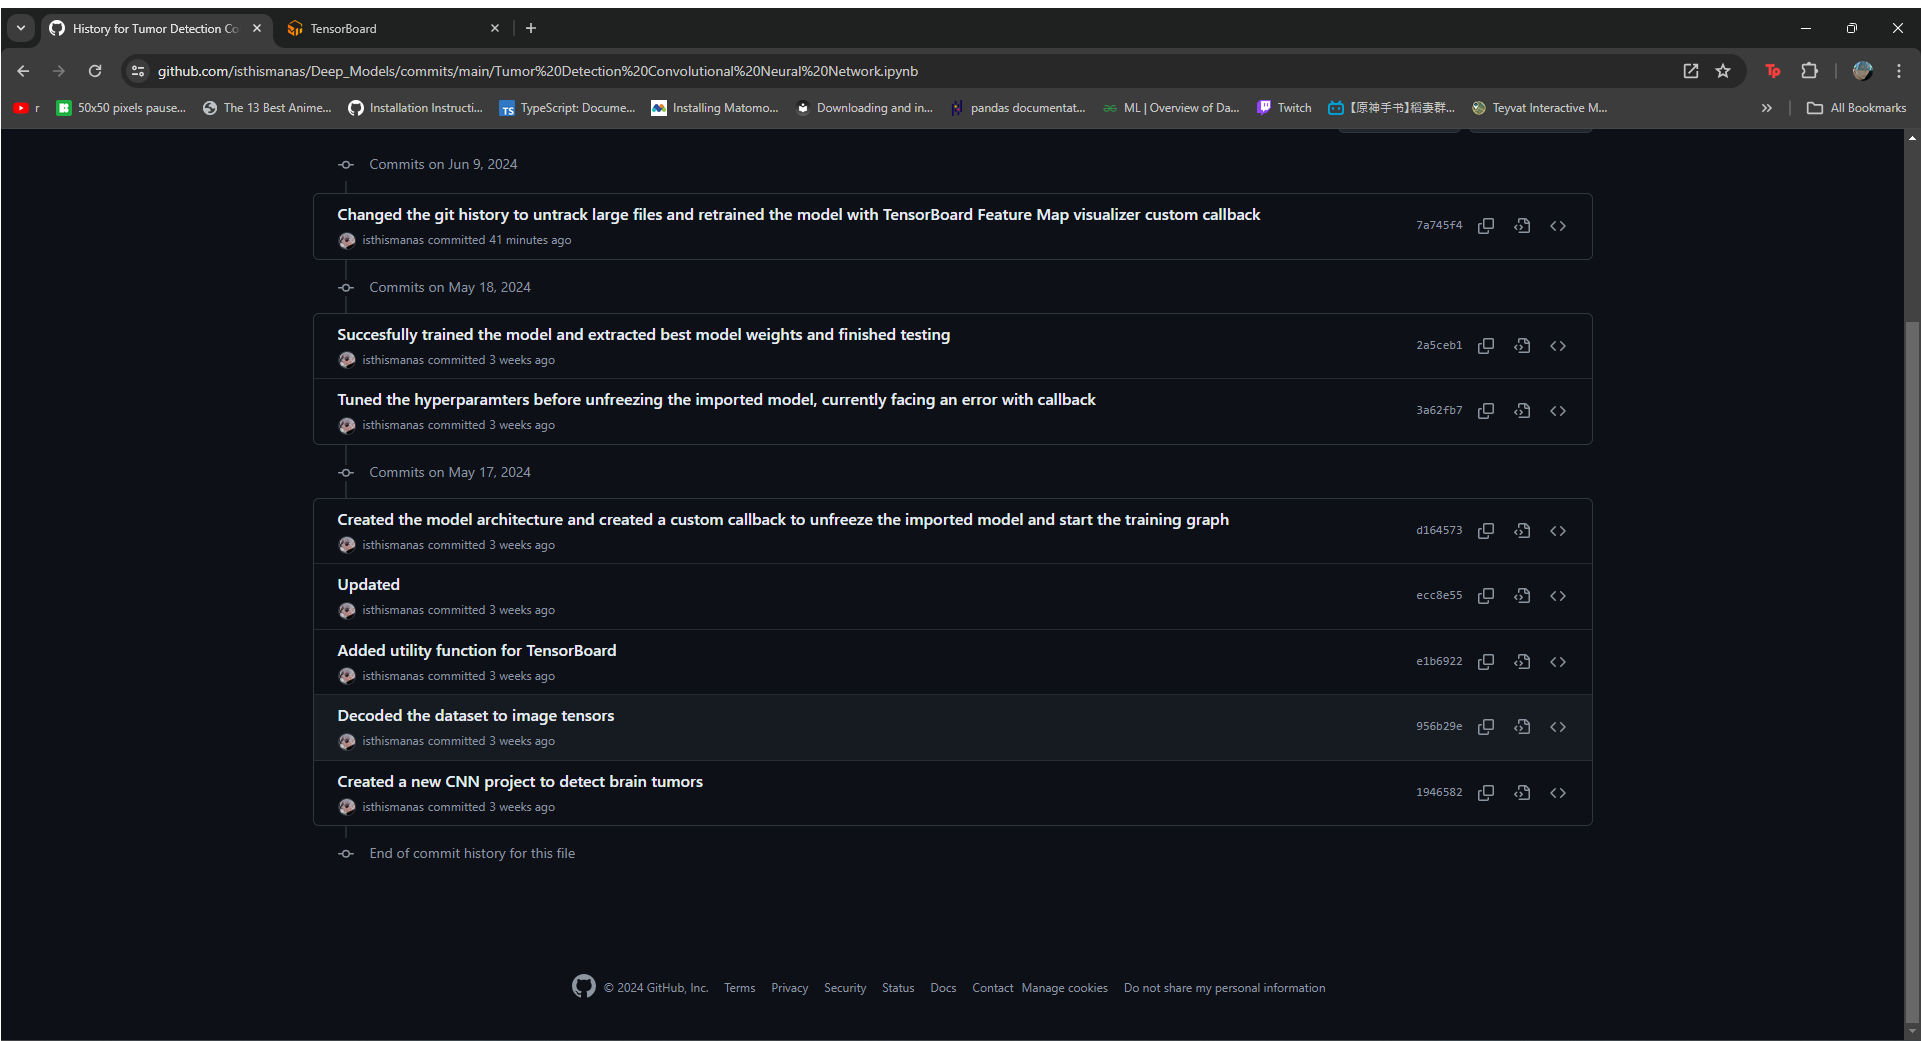
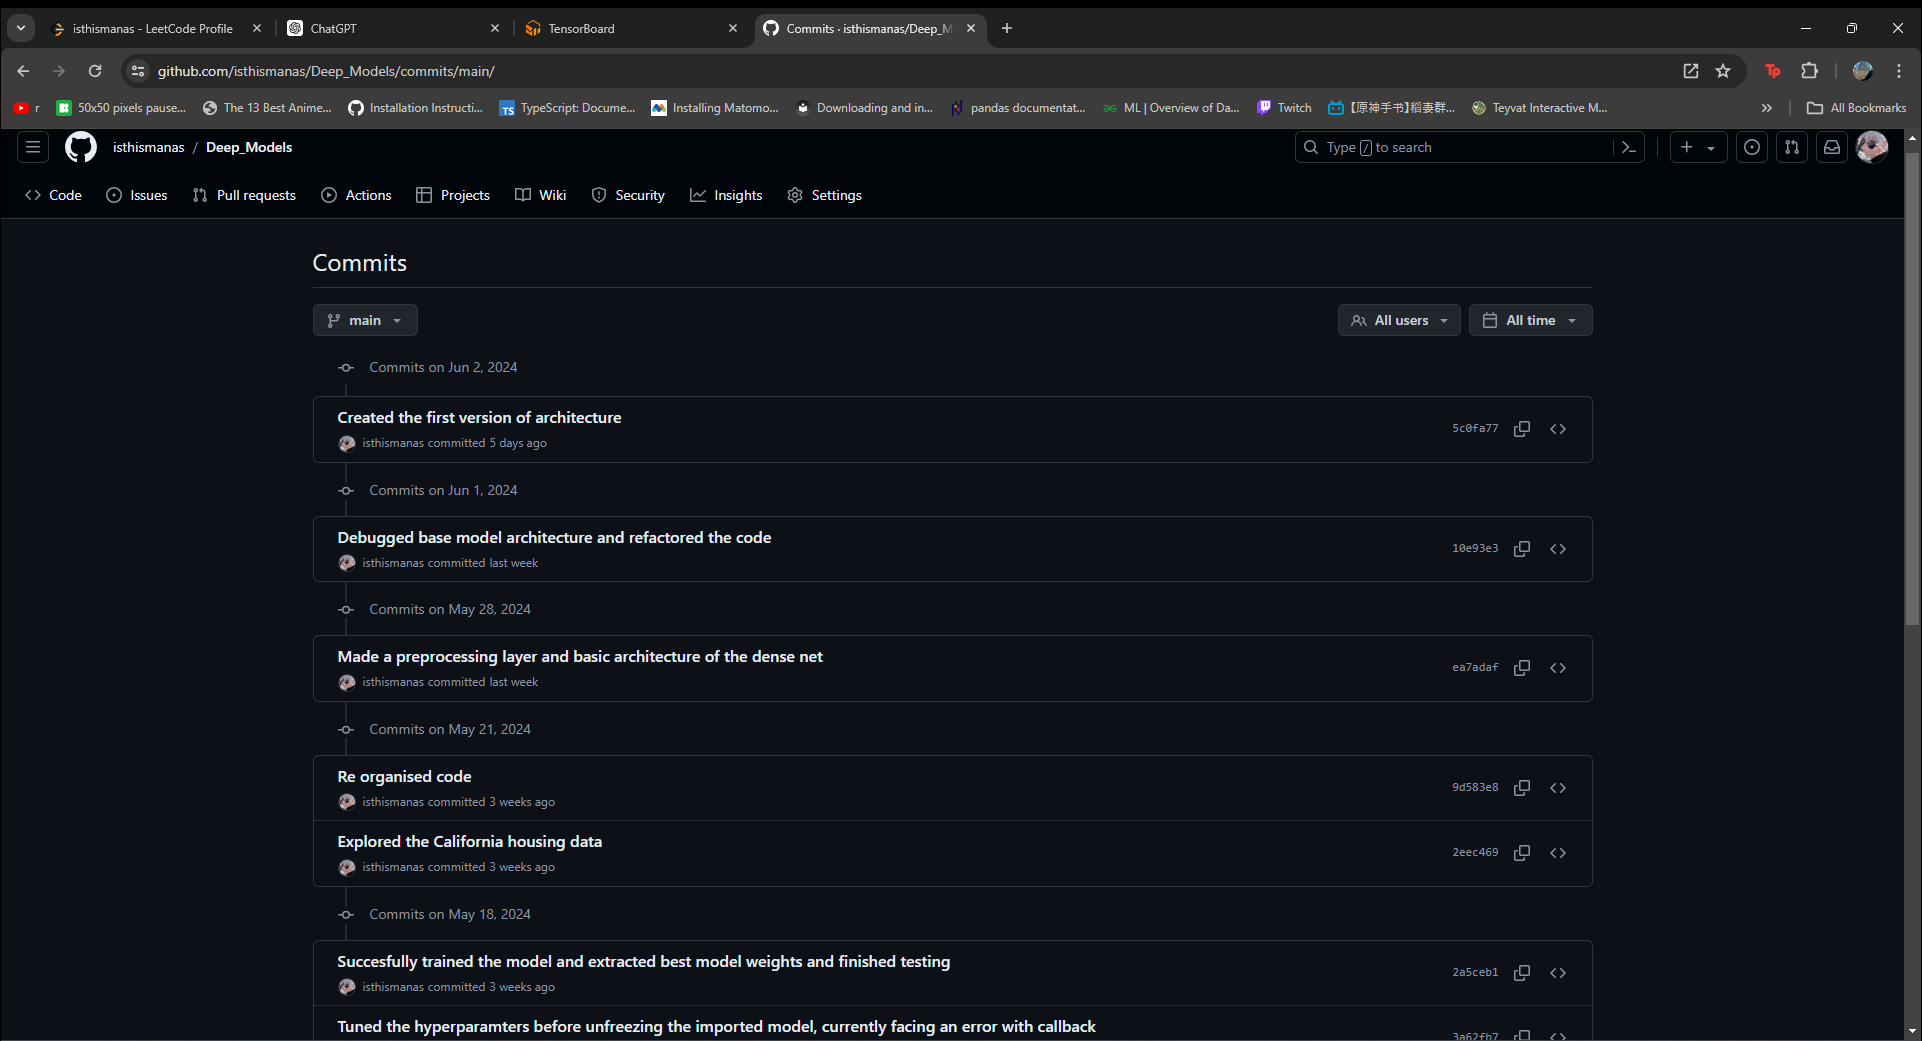
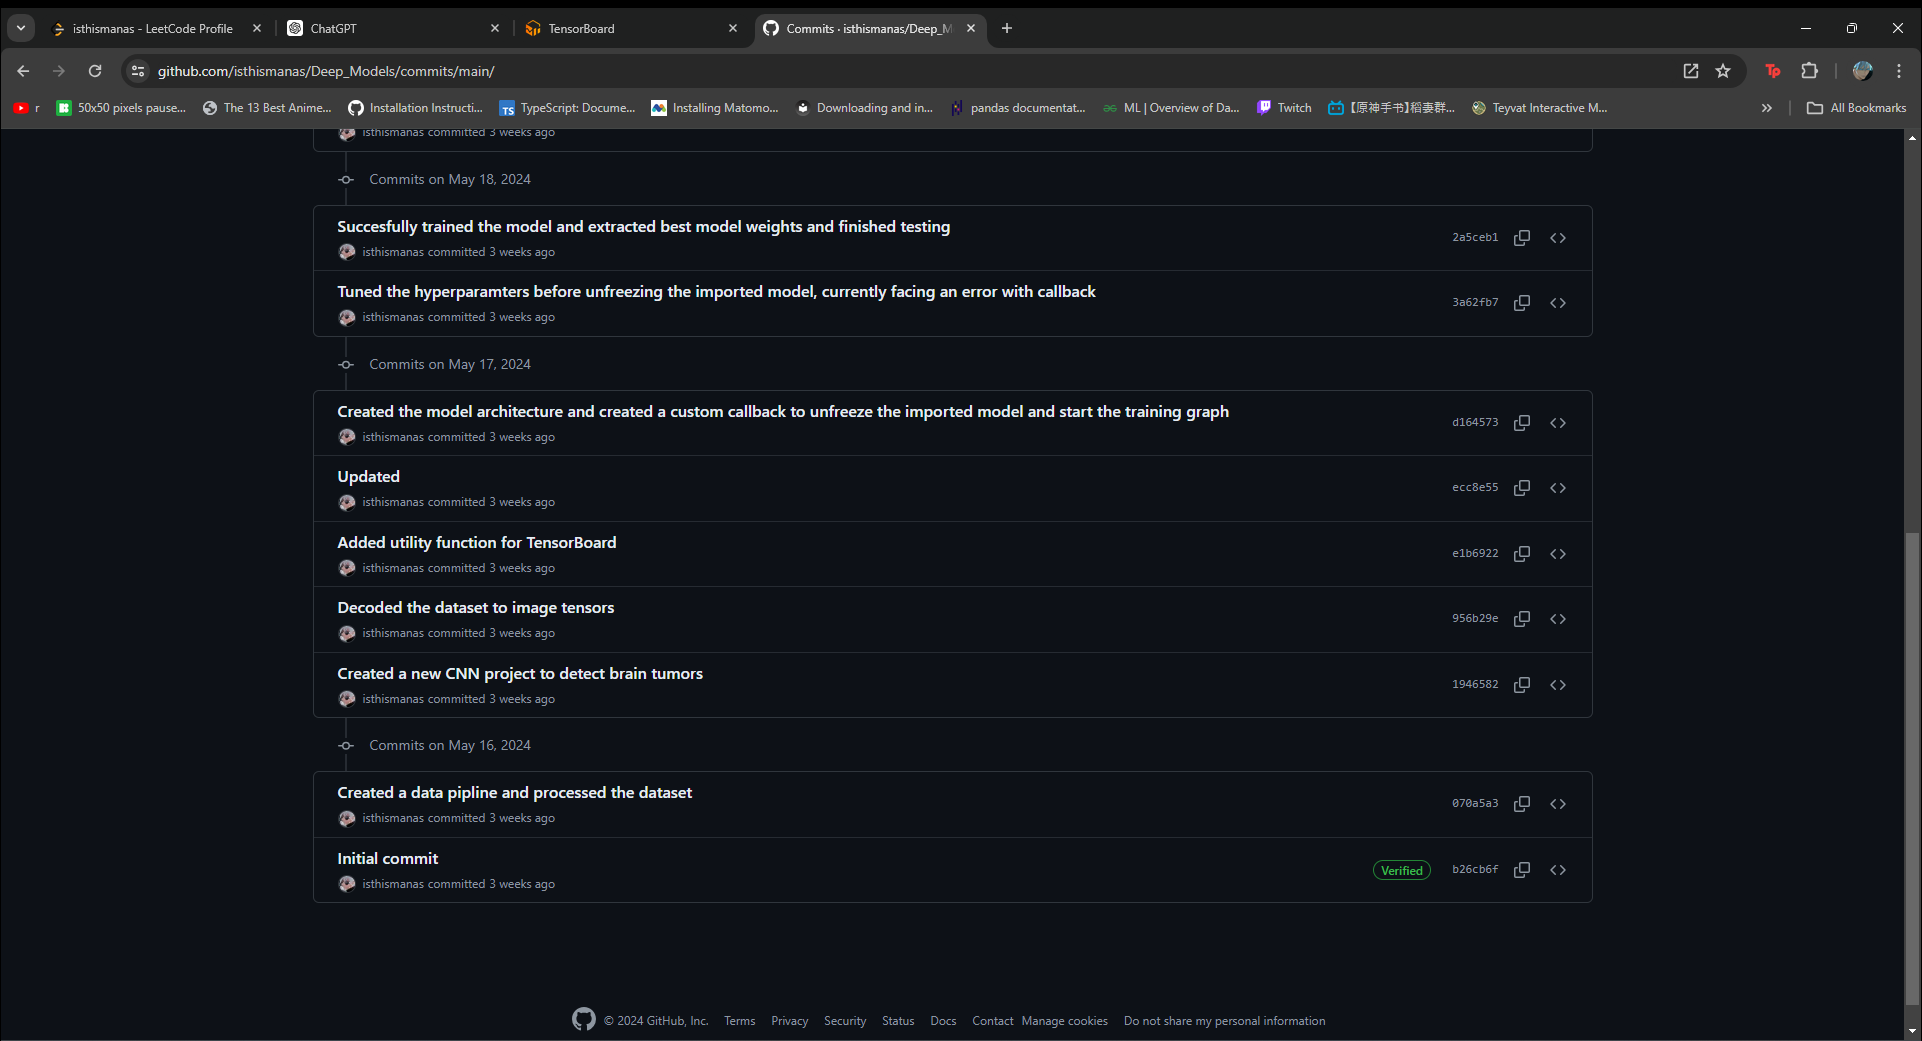
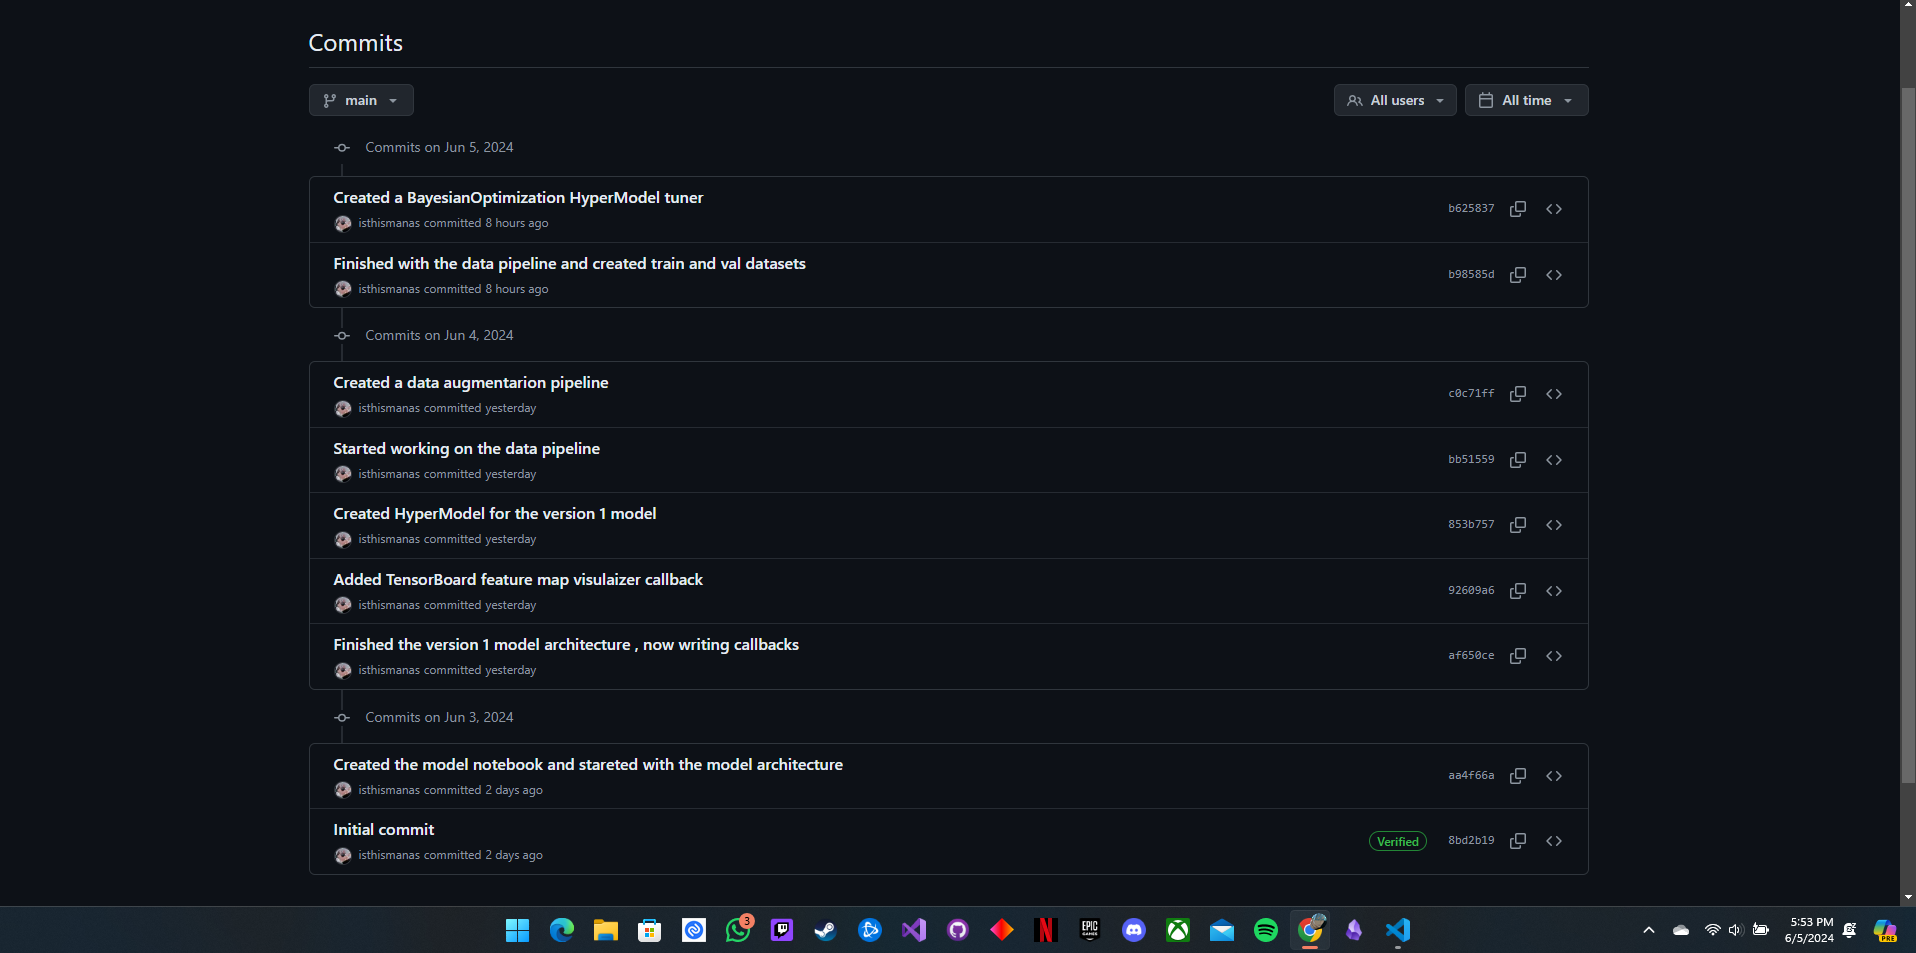